# COVID-19 Sentiment Analysis

The key goal of this project is to evaluate and visualize people’s mental health throughout the pandemic era of COVID-19.
In this project we are looking at the datset which is provided by kaggle see (https://www.kaggle.com/lpdataninja/spark-nlp)

Setup the libraries

In [0]:
#%%capture
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user
! pip install wordcloud


In [0]:
#%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F


import os

spark = SparkSession.builder.appName('COVID-19 Sentiment analysis').getOrCreate()


In [0]:
!pip install textblob 
#!python -m textblob.download_corpora
! pip install wordcloud

In [0]:

from pyspark.sql.functions import col, udf,regexp_replace,isnull, lower
import numpy as np
import pandas as pd
import matplotlib
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import time
import warnings

import textblob  
from textblob import TextBlob

import pandas as pd
import numpy as np

import os
os.environ['SPARK_HOME'] = "/content/spark-3.0.1-bin-hadoop3.2"

import pyspark
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer, CountVectorizer,StringIndexer, IDF,Tokenizer, HashingTF
from pyspark.sql.functions import expr
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.types import IntegerType, StringType


In [0]:
spark.sparkContext.setLogLevel('INFO')

In [0]:
spark.version

Out[89]: '2.4.5'

#Data loading
This dataset includes several months (and counting) of data on twitters. Data is included for numerous countries, with up to 32000 listed tweets.
Import your dataset using the following cells for the COVID-19 TWEETS

In [0]:
# read command but format as “CSV” to read csv files in Spark
# spark is not able to read columns properly from csv file
#  “inferSchema” and “header” to true, we can let spark know that first row in data is header
covid19_tweets_sdf = spark.read.format("csv").option("header", "true").load("/FileStore/tables/covid19_tweets.csv")

# createOrReplaceTempView() creates/replaces a local temp view with the dataframe provided.
# Lifetime of this view is dependent to SparkSession 
covid19_tweets_sdf.createOrReplaceTempView('covid19_tweets')
#from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType
#df = (sqlContext.read.format("csv").
#  option("header", "true").
#  option("nullValue", "NA").
#  option("inferSchema", True).
#  load("/FileStore/tables/flight_weather.csv"))
covid19_tweets_sdf.cache()

Out[90]: DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: string, user_friends: string, user_favourites: string, user_verified: string, date: string, text: string, hashtags: string, source: string, is_retweet: string]

In [0]:
covid19_tweets_sdf.count()

Out[91]: 323158

In [0]:
covid19_tweets_sdf.printSchema()

root
-- user_name: string (nullable = true)
-- user_location: string (nullable = true)
-- user_description: string (nullable = true)
-- user_created: string (nullable = true)
-- user_followers: string (nullable = true)
-- user_friends: string (nullable = true)
-- user_favourites: string (nullable = true)
-- user_verified: string (nullable = true)
-- date: string (nullable = true)
-- text: string (nullable = true)
-- hashtags: string (nullable = true)
-- source: string (nullable = true)
-- is_retweet: string (nullable = true)

In [0]:
covid19_tweets_sdf.describe()

Out[93]: DataFrame[summary: string, user_name: string, user_location: string, user_description: string, user_created: string, user_followers: string, user_friends: string, user_favourites: string, user_verified: string, date: string, text: string, hashtags: string, source: string, is_retweet: string]

In [0]:
covid19_tweets_sdf.show(5)

+---------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+-----------+-------------------+----------+
 user_name| user_location| user_description| user_created|user_followers|user_friends|user_favourites|user_verified| date| text| hashtags| source|is_retweet|
+---------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+-----------+-------------------+----------+
 ᏉᎥ☻լꂅϮ| astroworld|wednesday addams ...|2017-05-26 05:46:42| 624| 950| 18775| False|2020-07-25 12:27:21|If I smelled the ...| null| Twitter for iPhone| False|
Tom Basile 🇺🇸| New York, NY|Husband, Father, ...|2009-04-16 20:06:23| 2253| 1677| 24| True|2020-07-25 12:27:17|Hey @Yankees @Yan...| null|Twitter for Android| False|
Time4fisticuffs| Pewee Valley, KY|#Christian #Catho...|2009-02-28 18:57:41| 9275| 9525| 7254| False|2020-07-25 12:27:14|@diane3443 @wdunl...|['COVID19']|Twitter for Android| False|
 ethel mertz|Stuck in the Middle |#Browns #Indians ...|2019-03-07 01:45:06| 197| 987| 1488| False|2020-07-25 12:27:10|@brookbanktv The ...|['COVID19']| Twitter for iPhone| False|
 DIPR-J&K| Jammu and Kashmir|🖊️Official Twitt...|2017-02-12 06:45:15| 101009| 168| 101| False|2020-07-25 12:27:08|25 July : Media B...| null| null| null|
+---------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+-----------+-------------------+----------+
only showing top 5 rows

In [0]:
#user_followers: string (nullable = true)
 #|-- user_friends: string (nullable = true)
 #|-- user_favourites: string (nullable = true)
display(covid19_tweets_sdf)
#.show(truncate=False)

user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",null,Twitter for iPhone,False
Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,null,Twitter for Android,False
Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19,null,null,null
"@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh""","['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,null,null,null,null,null,null,null,null,null
🎹 Franz Schubert,Новоро́ссия,"🎼 #Новоро́ссия #Novorossiya #оставайсядома #STAYatHOME Polymath, composer, English.",2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXX2C,"['coronavirus', 'covid19']",Twitter Web App,False
hr bartender,"Gainesville, FL",Workplace tips and advice served up in a friendly place. Corporate blog of @ITMGroup by @Sharlyn_Lauby. Cheers!,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,"How #COVID19 Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK","['COVID19', 'Recruiting']",Buffer,False
Derbyshire LPC,null,null,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out shopping - this includes a visit to your local Community Pharmacy… https://t.co/OSu5Q4kdd7,null,TweetDeck,False
Prathamesh Bendre,null,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @ChouhanShivraj .,null,null,null


In [0]:
covid19_tweets_sdf.select("date").show(truncate=False)

+-------------------+
date |
+-------------------+
2020-07-25 12:27:21|
2020-07-25 12:27:17|
2020-07-25 12:27:14|
2020-07-25 12:27:10|
2020-07-25 12:27:08|
null |
2020-07-25 12:27:06|
2020-07-25 12:27:03|
2020-07-25 12:27:00|
2020-07-25 12:26:59|
null |
null |
2020-07-25 12:26:54|
null |
2020-07-25 12:26:53|
null |
null |
null |
null |
null |
+-------------------+
only showing top 20 rows

# Data Cleaning

##Drop Null Values
There are many colums which contains null values. Lets first drop those values

In [0]:
def null_count(df):
  null_columns_counts = []
  numRows = df.count()
  for kol in df.columns:
    nullRows = df.where(col(kol).isNull()).count()
    if(nullRows > 0):
      temp = kol,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [0]:
null_columns_count_list = null_count(covid19_tweets_sdf)

In [0]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()

+----------------------+-----------------+
Column_With_Null_Value|Null_Values_Count|
+----------------------+-----------------+
 user_name| 13|
 user_location| 99702|
 user_description| 70429|
 user_created| 87936|
 user_followers| 137502|
 user_friends| 142431|
 user_favourites| 143662|
 user_verified| 143944|
 date| 159247|
 text| 156615|
 hashtags| 232780|
 source| 212314|
 is_retweet| 213230|
+----------------------+-----------------+

AS we can see there 13 rows havinf null values for user_name lets actually drop these rows

In [0]:
covid19_tweets_sdf = covid19_tweets_sdf.dropna()

In [0]:
 covid19_tweets_sdf.count()

Out[101]: 58885

##Drop columns which are not required

In [0]:
covid19_tweets_sdf.drop("user_followers","user_friends","user_created","user_name")
covid19_tweets_sdf.show()

+--------------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
 user_name| user_location| user_description| user_created|user_followers|user_friends|user_favourites|user_verified| date| text| hashtags| source|is_retweet|
+--------------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
 Time4fisticuffs| Pewee Valley, KY|#Christian #Catho...|2009-02-28 18:57:41| 9275| 9525| 7254| False|2020-07-25 12:27:14|@diane3443 @wdunl...| ['COVID19']|Twitter for Android| False|
 ethel mertz|Stuck in the Middle |#Browns #Indians ...|2019-03-07 01:45:06| 197| 987| 1488| False|2020-07-25 12:27:10|@brookbanktv The ...| ['COVID19']| Twitter for iPhone| False|
 🎹 Franz Schubert| Новоро́ссия|🎼 #Новоро́ссия ...|2018-03-19 16:29:52| 1180| 1071| 1287| False|2020-07-25 12:27:06|#coronavirus #cov...|['coronavirus', '...| Twitter Web App| False|
 hr bartender| Gainesville, FL|Workplace tips an...|2008-08-12 18:19:49| 79956| 54810| 3801| False|2020-07-25 12:27:03|How #COVID19 Will...|['COVID19', 'Recr...| Buffer| False|
marc goovaerts🇪?...| Brussels|Progressive mind....|2009-06-13 13:48:16| 283| 1432| 1546| False|2020-07-25 12:26:44|Second wave of #C...|['COVID19', 'home...|Twitter for Android| False|
 Florian Bieber| Graz|Niko i ništa, pro...|2009-06-18 09:46:10| 18145| 1389| 13578| False|2020-07-25 12:26:28|Holy water in tim...| ['COVID19']|Twitter for Android| False|
Tetra Tech Intern...|Working in 175+ c...|A leader in #Glob...|2010-08-06 19:09:22| 20699| 458| 2680| False|2020-07-25 12:26:26|Our Munitions Res...|['BosniaandHerzeg...| Twitter Web App| False|
beatnikgeek the s...| Manhattan, NY|These days, I exp...|2008-02-23 19:02:29| 86| 259| 9412| False|2020-07-25 12:26:26|I can imagine the...| ['COVID19']|Twitter for Android| False|
 Beautify Data| Miami, FL|We beautify data ...|2019-02-18 17:11:24| 82| 92| 1152| False|2020-07-25 12:26:17|An update on the ...|['covid19', 'Afri...| Twitter Web App| False|
 Alan Taylor|British Columbia,...|Lifetime learner ...|2012-03-11 21:21:35| 54| 422| 1392| False|2020-07-25 12:26:15|@unionwill @megaw...| ['COVID19']| Twitter for iPad| False|
 Aishling Sheridan| Cavan, Ireland|Athletic therapis...|2011-12-21 18:19:44| 1136| 484| 2002| False|2020-07-25 12:25:58|#PlayYourPart in ...|['PlayYourPart', ...| Twitter for iPhone| False|
Matthew McGee ⴵ ?...|A UK I no longer ...|I am a man, and n...|2011-12-07 11:16:36| 3113| 3086| 221545| False|2020-07-25 12:25:56|Britain didn't un...| ['Covid19']|Twitter for Android| False|
 N I C TA S H ♍|Port Elizabeth, S...| I.G: @nictash_tash|2016-04-28 09:05:56| 481| 308| 1120| False|2020-07-25 12:25:50|Volume for those ...| ['COVID19']|Twitter for Android| False|
 TOI Delhi| New Delhi, India|Your city. Your n...|2009-04-13 13:00:35| 52186| 41| 74| True|2020-07-25 12:25:49|#Delhi reports 1,...|['Delhi', 'COVID19']| TweetDeck| False|
 Barry Grodenchik| Queens, NY|Queens lifer repr...|2012-11-23 16:51:09| 4868| 445| 31825| False|2020-07-25 12:25:30|.@nytimes reporti...| ['COVID19']|Twitter for Android| False|
 CARLINO| New Orleans, LA|IG Carlino213: Al...|2015-04-19 22:07:53| 11| 3| 133| False|2020-07-25 12:25:29|Crazy that the wo...| ['covid19']| Twitter for iPhone| False|
 ᏉᎥ☻լꂅϮ| astroworld|wednesday addams ...|2017-05-26 05:46:42| 624| 950| 18775| False|2020-07-25 12:25:24|I miss isopropyl ...| ['COVID19']| Twitter for iPhone| False|
 Jazmine❄️| Marietta, GA|Living Life Too T...|2009-04-26 04:34:30| 18092| 17557| 7156| False|2020-07-25 12:25:22|Due to #COVID19 a...|['COVID19', 'Coro...| Twitter for iPhone| False|
 Stephen Williams| Ballston Spa, NY|Longtime reporte...|2013-08-23 14:39:13| 1429| 926| 1324| False|2020-07-25 12:25:20|Local gover

## Week day - Data Transformation

In [0]:
from pyspark.sql.functions import to_timestamp,date_format
#.withColumn("week_day_abb", date_format(col("date"), "E"))
covid19_tweets_sdf = covid19_tweets_sdf.withColumn("date",to_timestamp(col("date"))).withColumn("week_day_number", date_format(col("date"), "u"))
covid19_tweets_sdf.select("date","week_day_number").show()


+-------------------+---------------+
 date|week_day_number|
+-------------------+---------------+
2020-07-25 12:27:14| 6|
2020-07-25 12:27:10| 6|
2020-07-25 12:27:06| 6|
2020-07-25 12:27:03| 6|
2020-07-25 12:26:44| 6|
2020-07-25 12:26:28| 6|
2020-07-25 12:26:26| 6|
2020-07-25 12:26:26| 6|
2020-07-25 12:26:17| 6|
2020-07-25 12:26:15| 6|
2020-07-25 12:25:58| 6|
2020-07-25 12:25:56| 6|
2020-07-25 12:25:50| 6|
2020-07-25 12:25:49| 6|
2020-07-25 12:25:30| 6|
2020-07-25 12:25:29| 6|
2020-07-25 12:25:24| 6|
2020-07-25 12:25:22| 6|
2020-07-25 12:25:20| 6|
2020-07-25 12:25:11| 6|
+-------------------+---------------+
only showing top 20 rows

# Data Visualization

### Frequent words used in tweeters

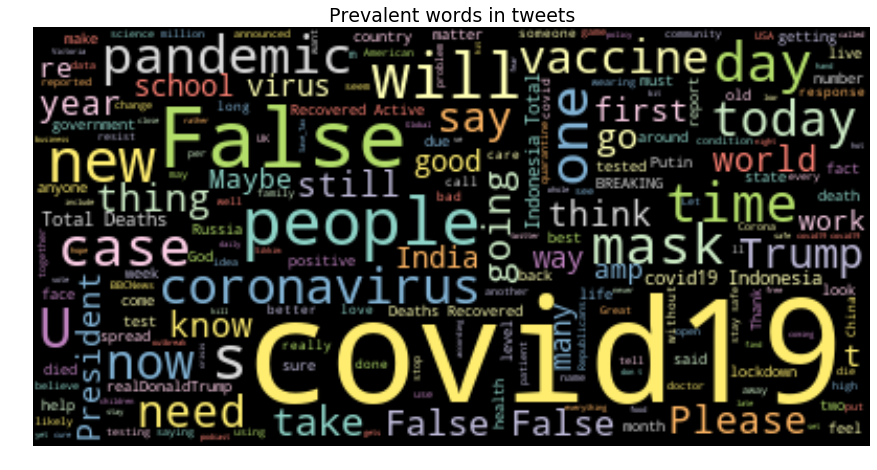

In [0]:
#texts = covid19_tweets_sdf.groupBy("text")
   
pandas_sdf = covid19_tweets_sdf.toPandas()

text = ",".join(review for review in pandas_sdf.text if 'COVID' not in review and 'https' not in review and 'Covid' not in review)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in tweets',fontsize=19)
plt.show()

###Plotting Top 10 most tweeter's source
Question - What kind of source did people use to tweet?

In [0]:
covid19_tweets_sdf.groupBy('source').count().orderBy(col("Count").desc()).show(5)
#user_location
#

+-------------------+-----+
 source|count|
+-------------------+-----+
 Twitter Web App|17964|
 Twitter for iPhone|13943|
Twitter for Android| 8939|
 TweetDeck| 3144|
 Hootsuite Inc.| 2976|
+-------------------+-----+
only showing top 5 rows

In [0]:
#covid19_tweets_sdf.groupBy("source").count().orderBy(col("Count").desc())
display(covid19_tweets_sdf.groupBy('source').count().orderBy(col("Count").desc()).limit(10))

source,count
Twitter Web App,17964
Twitter for iPhone,13943
Twitter for Android,8939
TweetDeck,3144
Hootsuite Inc.,2976
Twitter for iPad,1684
Buffer,1128
Sprout Social,831
Instagram,610
IFTTT,506


This is very likely when there are more Web users, so we're seeing a lot of counting on it. Then comes the Android & Iphone users standing next to the mobile browsers.

###Plotting Top 10 most tweeter's location
Question - Where do most tweets come from?

In [0]:
location_df = covid19_tweets_sdf.groupBy("user_location").count().orderBy(col("Count").desc()).show(20)

+----------------+-----+
 user_location|count|
+----------------+-----+
 India| 1302|
 United States| 1158|
 Washington, DC| 755|
 London, England| 566|
 New York, NY| 534|
New Delhi, India| 524|
 London| 490|
 United Kingdom| 472|
 Australia| 399|
 Mumbai, India| 399|
 New Delhi| 391|
 Atlanta, GA| 373|
 UK| 368|
 USA| 351|
 Los Angeles, CA| 340|
 Global| 339|
 South Africa| 329|
 Canada| 325|
 Earth| 323|
 California, USA| 305|
+----------------+-----+
only showing top 20 rows

In [0]:
display(covid19_tweets_sdf.groupBy("user_location").count().orderBy(col("Count").desc()).limit(10))

user_location,count
India,1302
United States,1158
"Washington, DC",755
"London, England",566
"New York, NY",534
"New Delhi, India",524
London,490
United Kingdom,472
Australia,399
"Mumbai, India",399


It is seen that India is the number one country to come from tweets, and then the number two to be washton, DC.

###List of the top retweeted tweets

In [0]:
fav_tweets = covid19_tweets_sdf.select("is_retweet","text")
fav_tweets = fav_tweets.withColumn("is_retweet",fav_tweets["is_retweet"].cast(IntegerType()))

fav_tweets.show(5)

+----------+--------------------+
is_retweet| text|
+----------+--------------------+
 null|@diane3443 @wdunl...|
 null|@brookbanktv The ...|
 null|#coronavirus #cov...|
 null|How #COVID19 Will...|
 null|Second wave of #C...|
+----------+--------------------+
only showing top 5 rows

In [0]:
display(fav_tweets.orderBy(col("is_retweet").desc()).limit(5))

is_retweet,text
38551,2016-03-22 12:53:27
21268,2015-03-13 04:21:24
5820,2010-07-25 23:35:54
5042,2009-03-23 19:48:05
5015,2008-07-30 07:18:35


###Top 5 among the most favorite tweets

In [0]:
fav_tweets = covid19_tweets_sdf.select("user_favourites","text")
fav_tweets.show(5)

+---------------+--------------------+
user_favourites| text|
+---------------+--------------------+
 7254|@diane3443 @wdunl...|
 1488|@brookbanktv The ...|
 1287|#coronavirus #cov...|
 3801|How #COVID19 Will...|
 1546|Second wave of #C...|
+---------------+--------------------+
only showing top 5 rows

In [0]:


fav_tweets = fav_tweets.withColumn("user_favourites",fav_tweets["user_favourites"].cast(IntegerType()))

fav_tweets.show(5)

+---------------+--------------------+
user_favourites| text|
+---------------+--------------------+
 7254|@diane3443 @wdunl...|
 1488|@brookbanktv The ...|
 1287|#coronavirus #cov...|
 3801|How #COVID19 Will...|
 1546|Second wave of #C...|
+---------------+--------------------+
only showing top 5 rows

In [0]:
display(fav_tweets.orderBy(col("user_favourites").desc()).limit(5))

user_favourites,text
2047197,So Trump wants everyone else's child to get #COVID19 but his son Baron gets an exception now that's messed up!!! 😡😤 https://t.co/hq5eZGjGY2
1320166,"So many conflicting reports, so much we don't know... why is it that the USA can't contain #COVID19 yet other count… https://t.co/n8kvYDFtDX"
1320166,"Interesting, since some say asymptomatic carriers are not the main spreaders of #COVID19? Which is it, other report… https://t.co/EdKH507rS3"
1320166,How do you pioneer a growing fatality rate and act like that's an accomplishment? #COVID19 https://t.co/8iS3ZPXNd3
1317944,"Sounds like the need for a booster shot, once a vaccine is made, for #COVID19 might be necessary based on this info… https://t.co/64hnbXS1mp"


###Tweets per day
Question - How many tweets were posted everyday?

In [0]:
covid19_tweets_sdf.groupBy("user_created").count().orderBy(col("Count").desc()).show(5)

+-------------------+-----+
 user_created|count|
+-------------------+-----+
2010-05-08 13:21:45| 197|
2017-09-15 19:54:39| 191|
2011-08-16 05:23:41| 152|
2008-08-16 10:09:33| 142|
2009-03-12 14:16:30| 135|
+-------------------+-----+
only showing top 5 rows

In [0]:
display(covid19_tweets_sdf.groupBy("user_created").count().orderBy(col("Count").desc()).limit(10))

user_created,count
2010-05-08 13:21:45,197
2017-09-15 19:54:39,191
2011-08-16 05:23:41,152
2008-08-16 10:09:33,142
2009-03-12 14:16:30,135
2010-01-27 22:48:24,134
2011-09-14 02:31:09,119
2009-06-04 21:26:24,117
2012-07-12 05:31:57,107
2009-06-22 12:41:39,97


###What hashtags has been viral? Most used in covid tweets?

In [0]:
import re
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
 #find_hash =  (str:String) => { line=re.findall(r'(?<=#)\w+',text) return " ".join(line) }

convertUDF = udf(lambda z:find_hash(z),StringType())

convertUDF2 = udf(lambda z : len(z.split(',')))

#covid19_tweets_sdf.select(col("text"),convertUDF(col("text")).as("hashs")).show(false)

covid19_tweets_sdf = covid19_tweets_sdf.withColumn("hash_count",convertUDF2(col("hashtags")))

display(covid19_tweets_sdf)


user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,week_day_number,hash_count
Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25T12:27:14.000+0000,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,6,1
ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25T12:27:10.000+0000,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False,6,1
🎹 Franz Schubert,Новоро́ссия,"🎼 #Новоро́ссия #Novorossiya #оставайсядома #STAYatHOME Polymath, composer, English.",2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25T12:27:06.000+0000,#coronavirus #covid19 deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXX2C,"['coronavirus', 'covid19']",Twitter Web App,False,6,2
hr bartender,"Gainesville, FL",Workplace tips and advice served up in a friendly place. Corporate blog of @ITMGroup by @Sharlyn_Lauby. Cheers!,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25T12:27:03.000+0000,"How #COVID19 Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK","['COVID19', 'Recruiting']",Buffer,False,6,2
marc goovaerts🇪🇺🏳️‍🌈,Brussels,"Progressive mind. Flemish. Into movies, politics, travelling, swimming, gym, massage and Indonesia",2009-06-13 13:48:16,283,1432,1546,False,2020-07-25T12:26:44.000+0000,Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN,"['COVID19', 'homework']",Twitter for Android,False,6,2
Florian Bieber,Graz,"Niko i ništa, professor, so-called Balkan expert, coordinator @biepag director @cseesgraz, Jean Monnet Chair, tweets English, manchmal Deutsch & ponekad naški.",2009-06-18 09:46:10,18145,1389,13578,False,2020-07-25T12:26:28.000+0000,Holy water in times of #COVID19 https://t.co/YaZ49yxL27,['COVID19'],Twitter for Android,False,6,1
Tetra Tech International Development,Working in 175+ countries,A leader in #GlobalDev. We work to improve livelihoods worldwide thru locally driven #sustainable #solutions. Posts by @TetraTech’s Int’l Dev team,2010-08-06 19:09:22,20699,458,2680,False,2020-07-25T12:26:26.000+0000,"Our Munitions Response Team in #BosniaandHerzegovina modified ops and adopted masks, disinfectants, and sanitizers… https://t.co/lMbKXlw1wQ",['BosniaandHerzegovina'],Twitter Web App,False,6,1
beatnikgeek the soothsayer,"Manhattan, NY","These days, I expose colonizers & exploits @ the subatomic level e.g., Unlimited profits is the only acceptable profit margin.",2008-02-23 19:02:29,86,259,9412,False,2020-07-25T12:26:26.000+0000,I can imagine the same people profiting off the human suffering of #COVID19 will be studying these maps to make 207… https://t.co/NElsmGju2H,['COVID19'],Twitter for Android,False,6,1
Beautify Data,"Miami, FL",We beautify data to learn and gain insight from data quicker.,2019-02-18 17:11:24,82,92,1152,False,2020-07-25T12:26:17.000+0000,"An update on the total #covid19 cases, recoveries, and deaths reported in countries in #Africa. See the total numb… https://t.co/eqCJ3EhwRi","['covid19', 'Africa']",Twitter Web App,False,6,2
Alan Taylor,"British Columbia, Canada",Lifetime learner and traveler. The only asset in life is time.,2012-03-11 21:21:35,54,422,1392,False,2020-07-25T12:26:15.000+0000,@unionwill @megawedgy @jjhorgan “Regarding the community outbreak of #COVID19 on Haida Gwaii: 13 cases (one recover… https://t.co/rJzuY60qY7,['COVID19'],Twitter for iPad,False,6,1


In [0]:
hash_array = []
hashList = covid19_tweets_sdf.select("hashtags").collect()

def add_hash(arr):
    for j in (arr): 
      z = (j.split(','))
      for k in z:
        k = k.replace('[','')
        k = k.replace(']','')
        hash_array.append(k)
      
convertUDF3 = udf(lambda z : add_hash(z))

#convertUDF3(col("hashtags"))

#hashList = covid19_tweets_sdf.withColumn("hashtags",convertUDF3(col("hashtags")))

top_tags = [str(t.hashtags) for t in covid19_tweets_sdf.select("hashtags").collect()]

add_hash(top_tags)
#print(hash_array)

new_sdf = covid19_tweets_sdf.withColumn("hashs",convertUDF3(col("hashtags"))).select("hashs","hashtags")

new_sdf.show(5)

display(new_sdf.groupBy(lower(col("hashtags"))).count().orderBy(col("count").desc()))

lower(hashtags),count
['covid19'],23801
"['coronavirus', 'covid19']",424
['coronavirus'],352
"['covid19', 'coronavirus']",325
false,148
"['coronavirus', 'scams', 'covid19']",104
"['covid19', 'vaccine']",93
"['covid19', 'pandemic']",90
"['india', 'covid19']",79
"['moneyforthepeople', 'covid19']",63


##Mentions
Let us find most mentioned user or organization in covid tweets

In [0]:
!pip install itertools
from itertools import chain
from collections import Counter

def find_at(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
  
convertUDF3 = udf(lambda z : find_at(z)) 

new_sdf = covid19_tweets_sdf.withColumn("mention",convertUDF3(col("text")))

mentions=[str(t.mention) for t in new_sdf.select("mention").collect()]
mentions = [each_string.lower().split() for each_string in mentions]
mentions=list(chain.from_iterable(mentions))
mention_df=dict(Counter(mentions))

top_mention_df=pd.DataFrame(list(mention_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_mention_df.head(10)


,word,count
2,realdonaldtrump,1197
62,who,193
46,gop,155
74,youtube,119
249,joebiden,112
703,potus,107
47,borisjohnson,103
125,cnn,97
123,cdcgov,89
363,narendramodi,86


In [0]:
display(top_mention_df)

word,count
realdonaldtrump,1197
who,193
gop,155
youtube,119
joebiden,112
potus,107
borisjohnson,103
cnn,97
cdcgov,89
narendramodi,86


here we could see Trump,Biden,Boris,Modi (Top Leaders) are tagged.Apart from them,WHO has paid attention to whole word.youtube is in the game too.

#Data preprocessing

##Converting string category to integer type

In [0]:
new_covid19_tweets_sdf = covid19_tweets_sdf.select("text","user_verified","is_retweet","week_day_number","user_favourites")
#.select("text","user_verified")
def convertToBinary(text):
    if text == "true":
      return 1
    else:
      return 0
  
convertUDF3 = udf(lambda z : convertToBinary(z))

new_covid19_tweets_sdf = new_covid19_tweets_sdf.withColumn("is_retweet",convertUDF3(col("is_retweet")).cast(IntegerType()))
new_covid19_tweets_sdf = new_covid19_tweets_sdf.withColumn("user_verified",convertUDF3(col("user_verified")).cast(IntegerType())) 
new_covid19_tweets_sdf = new_covid19_tweets_sdf.withColumn("week_day_number",new_covid19_tweets_sdf["week_day_number"].cast(IntegerType())) 
new_covid19_tweets_sdf = new_covid19_tweets_sdf.withColumn("user_favourites",new_covid19_tweets_sdf["user_favourites"].cast(IntegerType())) 

new_covid19_tweets_sdf.printSchema()

root
-- text: string (nullable = true)
-- user_verified: integer (nullable = true)
-- is_retweet: integer (nullable = true)
-- week_day_number: integer (nullable = true)
-- user_favourites: integer (nullable = true)

In [0]:
new_covid19_tweets_sdf.show(5)

+--------------------+-------------+----------+---------------+---------------+
 text|user_verified|is_retweet|week_day_number|user_favourites|
+--------------------+-------------+----------+---------------+---------------+
@diane3443 @wdunl...| 0| 0| 6| 7254|
@brookbanktv The ...| 0| 0| 6| 1488|
#coronavirus #cov...| 0| 0| 6| 1287|
How #COVID19 Will...| 0| 0| 6| 3801|
Second wave of #C...| 0| 0| 6| 1546|
+--------------------+-------------+----------+---------------+---------------+
only showing top 5 rows

In [0]:
new_covid19_tweets_sdf.dropna()

Out[122]: DataFrame[text: string, user_verified: int, is_retweet: int, week_day_number: int, user_favourites: int]

## Convert text using counter vectorization

In [0]:
txt_category = new_covid19_tweets_sdf.withColumn("Str_Tweets",regexp_replace(col('text'), '\d+', ''))
txt_category.select("text","Str_Tweets").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+
text |Str_Tweets |
+------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+
@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3 |@diane @wdunlap @realDonaldTrump Trump never once claimed #COVID was a hoax. We all claim that this effort to… https://t.co/JkkvHWHb |
@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW |@brookbanktv The one gift #COVID has give me is an appreciation for the simple things that were always around me… https://t.co/ZpOAlFXcW |
#coronavirus #covid19 deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXX2C |#coronavirus #covid deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXXC |
How #COVID19 Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK |How #COVID Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK |
Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN |Second wave of #COVID in Flanders..back to more #homework again... https://t.co/swImZACMN |
Holy water in times of #COVID19 https://t.co/YaZ49yxL27 |Holy water in times of #COVID https://t.co/YaZyxL |
Our Munitions Response Team in #BosniaandHerzegovina modified ops and adopted masks, disinfectants, and sanitizers… https://t.co/lMbKXlw1wQ |Our Munitions Response Team in #BosniaandHerzegovina modified ops and adopted masks, disinfectants, and sanitizers… https://t.co/lMbKXlwwQ|
I can imagine the same people profiting off the human suffering of #COVID19 will be studying these maps to make 207… https://t.co/NElsmGju2H |I can imagine the same people profiting off the human suffering of #COVID will be studying these maps to make … https://t.co/NElsmGjuH |
An update on the total #covid19 cases, recoveries, and deaths reported in countries in #Africa. See the total numb… https://t.co/eqCJ3EhwRi |An update on the total #covid cases, recoveries, and deaths reported in countries in #Africa. See the total numb… https://t.co/eqCJEhwRi |
@unionwill @megawedgy @jjhorgan “Regarding the community outbreak of #COVID19 on Haida Gwaii: 13 cases (one recover… https://t.co/rJzuY60qY7 |@unionwill @megawedgy @jjhorgan “Regarding the community outbreak of #COVID on Haida Gwaii: cases (one recover… https://t.co/rJzuYqY |
#PlayYourPart in the fight against #COVID19 . Each one of us can make a difference in containing the spread, lets… https://t.co/fRzLgrS8Qf |#PlayYourPart in the fight against #COVID . Each one of us can make a difference in containing the spread, lets… https://t.co/fRzLgrSQf |
Britain didn't understand #Covid19 for months, while plenty of other countries did understand it and took effective… https://t.co/KV2CAQ6skZ |Britain didn't understand #Covid for months, while plenty of other countries did understand it and took effective… https://t.co/KVCAQskZ |
Volume for those at the back please. 🔊 #COVID19 https://t.co/d0pn2Bv2Hx |Volume for those at the back please. 🔊 #COVID https://t.co/dpnBvHx |
#Delhi reports 1,142 #COVID19 positive cases and 29 deaths on Saturday. Death toll rises to 3,806, reports ANI quot… https://t.co/JxsVpWMRQS |#Delhi reports , #COVID positive cases and deaths on Sat

##Splitting text into words

In [0]:
regex_tokenizer = RegexTokenizer(inputCol="Str_Tweets", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(txt_category)
raw_words.show()

+--------------------+-------------+----------+---------------+---------------+--------------------+--------------------+
 text|user_verified|is_retweet|week_day_number|user_favourites| Str_Tweets| words|
+--------------------+-------------+----------+---------------+---------------+--------------------+--------------------+
@diane3443 @wdunl...| 0| 0| 6| 7254|@diane @wdunlap @...|[diane, wdunlap, ...|
@brookbanktv The ...| 0| 0| 6| 1488|@brookbanktv The ...|[brookbanktv, the...|
#coronavirus #cov...| 0| 0| 6| 1287|#coronavirus #cov...|[coronavirus, cov...|
How #COVID19 Will...| 0| 0| 6| 3801|How #COVID Will C...|[how, covid, will...|
Second wave of #C...| 0| 0| 6| 1546|Second wave of #C...|[second, wave, of...|
Holy water in tim...| 0| 0| 6| 13578|Holy water in tim...|[holy, water, in,...|
Our Munitions Res...| 0| 0| 6| 2680|Our Munitions Res...|[our, munitions, ...|
I can imagine the...| 0| 0| 6| 9412|I can imagine the...|[i, can, imagine,...|
An update on the ...| 0| 0| 6| 1152|An update on the ...|[an, update, on, ...|
@unionwill @megaw...| 0| 0| 6| 1392|@unionwill @megaw...|[unionwill, megaw...|
#PlayYourPart in ...| 0| 0| 6| 2002|#PlayYourPart in ...|[playyourpart, in...|
Britain didn't un...| 0| 0| 6| 221545|Britain didn't un...|[britain, didn, t...|
Volume for those ...| 0| 0| 6| 1120|Volume for those ...|[volume, for, tho...|
#Delhi reports 1,...| 0| 0| 6| 74|#Delhi reports , ...|[delhi, reports, ...|
.@nytimes reporti...| 0| 0| 6| 31825|.@nytimes reporti...|[nytimes, reporti...|
Crazy that the wo...| 0| 0| 6| 133|Crazy that the wo...|[crazy, that, the...|
I miss isopropyl ...| 0| 0| 6| 18775|I miss isopropyl ...|[i, miss, isoprop...|
Due to #COVID19 a...| 0| 0| 6| 7156|Due to #COVID aka...|[due, to, covid, ...|
Local government ...| 0| 0| 6| 1324|Local government ...|[local, governmen...|
Check out Angel's...| 0| 0| 6| 1204|Check out Angel's...|[check, out, ange...|
+--------------------+-------------+----------+---------------+---------------+--------------------+--------------------+
only showing top 20 rows

##Removing stop words

In [0]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)
new_covid19_tweets_sdf = words_df.drop("text","words") #,"Str_Tweets"
#new_covid19_tweets_sdf = words_df
display(new_covid19_tweets_sdf)

user_verified,is_retweet,week_day_number,user_favourites,Str_Tweets,filtered
0,0,6,7254,@diane @wdunlap @realDonaldTrump Trump never once claimed #COVID was a hoax. We all claim that this effort to… https://t.co/JkkvHWHb,"List(diane, wdunlap, realdonaldtrump, trump, never, claimed, covid, hoax, claim, effort, https, co, jkkvhwhb)"
0,0,6,1488,@brookbanktv The one gift #COVID has give me is an appreciation for the simple things that were always around me… https://t.co/ZpOAlFXcW,"List(brookbanktv, one, gift, covid, give, appreciation, simple, things, always, around, https, co, zpoalfxcw)"
0,0,6,1287,#coronavirus #covid deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXXC,"List(coronavirus, covid, deaths, continue, rise, almost, bad, ever, politicians, businesses, want, https, co, hxmhooxxc)"
0,0,6,3801,"How #COVID Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK","List(covid, change, work, general, recruiting, specifically, via, proactivetalent, recruiting, https, co, bjzxzgpmbk)"
0,0,6,1546,Second wave of #COVID in Flanders..back to more #homework again... https://t.co/swImZACMN,"List(second, wave, covid, flanders, back, homework, https, co, swimzacmn)"
0,0,6,13578,Holy water in times of #COVID https://t.co/YaZyxL,"List(holy, water, times, covid, https, co, yazyxl)"
0,0,6,2680,"Our Munitions Response Team in #BosniaandHerzegovina modified ops and adopted masks, disinfectants, and sanitizers… https://t.co/lMbKXlwwQ","List(munitions, response, team, bosniaandherzegovina, modified, ops, adopted, masks, disinfectants, sanitizers, https, co, lmbkxlwwq)"
0,0,6,9412,I can imagine the same people profiting off the human suffering of #COVID will be studying these maps to make … https://t.co/NElsmGjuH,"List(imagine, people, profiting, human, suffering, covid, studying, maps, make, https, co, nelsmgjuh)"
0,0,6,1152,"An update on the total #covid cases, recoveries, and deaths reported in countries in #Africa. See the total numb… https://t.co/eqCJEhwRi","List(update, total, covid, cases, recoveries, deaths, reported, countries, africa, see, total, numb, https, co, eqcjehwri)"
0,0,6,1392,@unionwill @megawedgy @jjhorgan “Regarding the community outbreak of #COVID on Haida Gwaii: cases (one recover… https://t.co/rJzuYqY,"List(unionwill, megawedgy, jjhorgan, regarding, community, outbreak, covid, haida, gwaii, cases, one, recover, https, co, rjzuyqy)"


#Text Sentiment

## Find sentiment score

In [0]:
#import nltk
from pyspark.sql.types import FloatType
#from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

sentiment_polarity_udf = udf(polarity , FloatType())

new_covid19_tweets_sdf  = new_covid19_tweets_sdf.withColumn("sentiment_score", sentiment_polarity_udf( new_covid19_tweets_sdf['Str_Tweets'] ))
new_covid19_tweets_sdf.show(5)


+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+
user_verified|is_retweet|week_day_number|user_favourites| Str_Tweets| filtered|sentiment_score|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+
 0| 0| 6| 7254|@diane @wdunlap @...|[diane, wdunlap, ...| 0.0|
 0| 0| 6| 1488|@brookbanktv The ...|[brookbanktv, one...| 0.0|
 0| 0| 6| 1287|#coronavirus #cov...|[coronavirus, cov...| -0.7|
 0| 0| 6| 3801|How #COVID Will C...|[covid, change, w...| 0.05|
 0| 0| 6| 1546|Second wave of #C...|[second, wave, co...| 0.25|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+
only showing top 5 rows

## Find sentiment from sentiment score

In [0]:
def findSentiment(r):
    if (r >=0.1):
        label = "positive"
    elif(r <= -0.1):
        label = "negative"
    else:
        label = "neutral"
    return label

sentiment_udf = udf(lambda x: findSentiment(x), StringType())

new_covid19_tweets_sdf  = new_covid19_tweets_sdf.withColumn("sentiment", sentiment_udf( new_covid19_tweets_sdf['sentiment_score'] ))
new_covid19_tweets_sdf.show(5,True)

+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
user_verified|is_retweet|week_day_number|user_favourites| Str_Tweets| filtered|sentiment_score|sentiment|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
 0| 0| 6| 7254|@diane @wdunlap @...|[diane, wdunlap, ...| 0.0| neutral|
 0| 0| 6| 1488|@brookbanktv The ...|[brookbanktv, one...| 0.0| neutral|
 0| 0| 6| 1287|#coronavirus #cov...|[coronavirus, cov...| -0.7| negative|
 0| 0| 6| 3801|How #COVID Will C...|[covid, change, w...| 0.05| neutral|
 0| 0| 6| 1546|Second wave of #C...|[second, wave, co...| 0.25| positive|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
only showing top 5 rows

## Total number of neutral , positive, negative sentiment available in twitter text

In [0]:
new_covid19_tweets_sdf.groupBy("sentiment").count().orderBy(col("Count").desc()).show(5)

+---------+-----+
sentiment|count|
+---------+-----+
 neutral|31005|
 positive|20298|
 negative| 7582|
+---------+-----+

In [0]:
display(new_covid19_tweets_sdf.groupBy("sentiment").count().orderBy(col("Count").desc()))

sentiment,count
neutral,31005
positive,20298
negative,7582


In [0]:
new_covid19_tweets_sdf.filter(col("sentiment") == "positive").orderBy(col("user_favourites").desc()).show(5)

+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
user_verified|is_retweet|week_day_number|user_favourites| Str_Tweets| filtered|sentiment_score|sentiment|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
 0| 0| 6| 2047197|So Trump wants ev...|[trump, wants, ev...| 0.390625| positive|
 0| 0| 7| 1320166|So many conflicti...|[many, conflictin...| 0.19166666| positive|
 0| 0| 7| 1320166|Interesting, sinc...|[interesting, sin...| 0.18055555| positive|
 0| 0| 5| 741591|More news media m...|[news, media, mus...| 0.5| positive|
 0| 0| 4| 738087|When one American...|[one, american, d...| 0.14285715| positive|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+
only showing top 5 rows

In [0]:
sentiment_df = new_covid19_tweets_sdf.filter(col("sentiment") == "positive").orderBy(col("user_favourites").desc())
sentiment_df = sentiment_df.select("user_favourites","sentiment")
display(sentiment_df)

user_favourites,sentiment
2047197,positive
1320166,positive
1320166,positive
741591,positive
738087,positive
676255,positive
663249,positive
658802,positive
654023,positive
654023,positive


# Feature Enginnering

## Splitting the data (train,test)

In [0]:
(train_sdf, test_sdf) = new_covid19_tweets_sdf.randomSplit([0.8, 0.2])

## Identifying categories

In [0]:
#"text","user_verified","is_retweet","week_day_number","user_favourites"
sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
user_verified_indexer = StringIndexer(inputCol="user_verified", outputCol="user_verified_index")
retweet_indexer = StringIndexer(inputCol="is_retweet", outputCol="is_retweet_index")

#feature_data = indexer.fit(words_df).transform(words_df)
#feature_data.show()

##Assembler

In [0]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[
    "user_favourites",
    "user_verified_index",
    "is_retweet_index",
    "week_day_number",
    "sentiment_index"
    ], outputCol='features')
assembler = assembler.setHandleInvalid("skip")

##Count Vectorization

In [0]:

# Count the words in a document
#hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
#tf = hashingTF.transform(feature_data)

#idf = IDF(inputCol="rawFeatures", outputCol="features")
#idfModel = idf.fit(tf) 
#countVectorizer_feateures = idfModel.transform(tf)

cv = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
#model = cv.fit(feature_data)
#countVectorizer_feateures = model.transform(feature_data)

## Pipeline

In [0]:
from pyspark.ml import Pipeline

# setting up the pipeline
pipeline = Pipeline(stages=[sentiment_indexer,user_verified_indexer,retweet_indexer,assembler,cv])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(train_sdf)
modified_data_sdf = pipeline_model.transform(test_sdf)

In [0]:
pipeline_stat = pd.DataFrame(modified_data_sdf.take(5), columns=modified_data_sdf.columns)
print('check_pipeline', (pipeline_stat.columns.values, pipeline_stat['features'][0].size))

check_pipeline (array(['user_verified', 'is_retweet', 'week_day_number',
 'user_favourites', 'Str_Tweets', 'filtered', 'sentiment_score',
 'sentiment', 'sentiment_index', 'user_verified_index',
 'is_retweet_index', 'features', 'rawFeatures'], dtype=object), 5)

In [0]:
modified_data_sdf.show(5)

+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+---------------+-------------------+----------------+--------------------+--------------------+
user_verified|is_retweet|week_day_number|user_favourites| Str_Tweets| filtered|sentiment_score|sentiment|sentiment_index|user_verified_index|is_retweet_index| features| rawFeatures|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+---------------+-------------------+----------------+--------------------+--------------------+
 0| 0| 3| 3| False| [false]| -0.4| negative| 2.0| 0.0| 0.0|[3.0,0.0,0.0,3.0,...| (94298,[922],[1.0])|
 0| 0| 5| 54|We are definitely...|[definitely, seei...| 0.0| neutral| 0.0| 0.0| 0.0|(5,[0,3],[54.0,5.0])|(94298,[0,1,2,751...|
 0| 0| 5| 83|First job in a lo...|[first, job, long...| 0.0875| neutral| 0.0| 0.0| 0.0|(5,[0,3],[83.0,5.0])|(94298,[0,1,2,32,...|
 0| 0| 5| 278|"#NewJersey had t...|[newjersey, th, e...| 0.25| positive| 1.0| 0.0| 0.0|[278.0,0.0,0.0,5....|(94298,[2,7,48,13...|
 0| 0| 5| 439|The theme of the ...|[theme, latest, c...| 0.5| positive| 1.0| 0.0| 0.0|[439.0,0.0,0.0,5....|(94298,[0,1,2,65,...|
+-------------+----------+---------------+---------------+--------------------+--------------------+---------------+---------+---------------+-------------------+----------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
(trainingData, testData) = modified_data_sdf.randomSplit([0.8, 0.2],seed = 11)

##Naive bayes classification

### Model Training

In [0]:
nb = NaiveBayes(modelType="multinomial",labelCol="sentiment_index", featuresCol="features")
nbModel = nb.fit(trainingData)
nb_predictions = nbModel.transform(testData)

In [0]:
nb_predictions.select("prediction","sentiment_index", "features").show(5)

+----------+---------------+--------------------+
prediction|sentiment_index| features|
+----------+---------------+--------------------+
 1.0| 1.0|[278.0,0.0,0.0,5....|
 0.0| 0.0|(5,[0,3],[2956.0,...|
 0.0| 0.0|(5,[0,3],[7728.0,...|
 0.0| 0.0|(5,[0,3],[8124.0,...|
 1.0| 1.0| (5,[3,4],[6.0,1.0])|
+----------+---------------+--------------------+
only showing top 5 rows

### Evaluation

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))
print("Test Error of NaiveBayes = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is = 0.843394
Test Error of NaiveBayes = 0.156606

## Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
randomforest = RandomForestClassifier(labelCol="sentiment_index", featuresCol="features", numTrees=5)
rfModel = randomforest.fit(trainingData)
rf_prediction = rfModel.transform(testData)
rf_prediction.select("prediction","sentiment_index", "features").show(5)

+----------+---------------+--------------------+
prediction|sentiment_index| features|
+----------+---------------+--------------------+
 1.0| 1.0|[278.0,0.0,0.0,5....|
 0.0| 0.0|(5,[0,3],[2956.0,...|
 0.0| 0.0|(5,[0,3],[7728.0,...|
 0.0| 0.0|(5,[0,3],[8124.0,...|
 1.0| 1.0| (5,[3,4],[6.0,1.0])|
+----------+---------------+--------------------+
only showing top 5 rows

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of Random Forest is = %g"% (rf_accuracy))
print("Test Error of Random Forest = %g " % (1.0 - rf_accuracy))

Accuracy of Random Forest is = 1
Test Error of Random Forest = 0

##Logistic Regression

### Model creating and Training

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol='sentiment_index', regParam=0.1)

In [0]:
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)

In [0]:
lr_prediction.select("prediction","sentiment_index", "features").show(5)

+----------+---------------+--------------------+
prediction|sentiment_index| features|
+----------+---------------+--------------------+
 1.0| 1.0|[278.0,0.0,0.0,5....|
 0.0| 0.0|(5,[0,3],[2956.0,...|
 0.0| 0.0|(5,[0,3],[7728.0,...|
 0.0| 0.0|(5,[0,3],[8124.0,...|
 1.0| 1.0| (5,[3,4],[6.0,1.0])|
+----------+---------------+--------------------+
only showing top 5 rows

### Evaluation

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Compute RMSr on the test set
evaluator = RegressionEvaluator(
    labelCol="sentiment_index", predictionCol="prediction", metricName="rmse")

test_result = evaluator.evaluate(lr_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result)


Root Mean Squared Error (RMSE) on test data = 0.315627

In [0]:
y_senti = lr_prediction.select("sentiment_index").toPandas()
y_predi = lr_prediction.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_senti, y_predi)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.7983729446326575